In [21]:
import numpy as np
import matplotlib.pyplot as plt
import laspy
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter

In [3]:
las_file_path = r"C:\Users\lliu\Desktop\FrontierSI\projects\GA_floor_height\QA4lidar\2_clipped_buffered.las"

In [7]:
def remove_noise(points, eps, min_samples):
    """
    Remove noise points by filtering out isolated clusters using DBSCAN.

    Parameters:
        points (numpy.ndarray): LiDAR points as an (N, 3) array of [x, y, z].
        eps (float): Maximum distance between points to be considered in the same neighborhood.
        min_samples (int): Minimum number of points to form a dense cluster.

    Returns:
        numpy.ndarray: Filtered points with noise removed.
    """
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points[:, :2])
    labels = clustering.labels_

    # Keep only points belonging to clusters (label != -1)
    return points[labels != -1]

def create_bev_density_map(points, x_limits, y_limits, resolution=0.1):
    """
    Project LiDAR point cloud to BEV plane as a density map.

    Parameters:
        points (numpy.ndarray): LiDAR points as an (N, 3) array of [x, y, z].
        x_limits (tuple): Min and max range for x-axis (e.g., (-50, 50)).
        y_limits (tuple): Min and max range for y-axis (e.g., (-50, 50)).
        resolution (float): Grid resolution in meters (e.g., 0.1).

    Returns:
        density_map (numpy.ndarray): Gridded density map as a 2D array.
    """
    # Filter points within the specified x and y limits
    x_min, x_max = x_limits
    y_min, y_max = y_limits

    mask = (
        (points[:, 0] >= x_min) & (points[:, 0] < x_max) &
        (points[:, 1] >= y_min) & (points[:, 1] < y_max)
    )
    filtered_points = points[mask]

    # Calculate grid size
    grid_x_size = int((x_max - x_min) / resolution)
    grid_y_size = int((y_max - y_min) / resolution)

    # Convert points to grid coordinates
    grid_x = ((filtered_points[:, 0] - x_min) / resolution).astype(np.int32)
    grid_y = ((filtered_points[:, 1] - y_min) / resolution).astype(np.int32)

    # Clip indices to ensure they are within valid range
    grid_x = np.clip(grid_x, 0, grid_x_size - 1)
    grid_y = np.clip(grid_y, 0, grid_y_size - 1)

    # Initialize density map
    density_map = np.zeros((grid_y_size, grid_x_size), dtype=np.float32)

    # Populate density map
    for gx, gy in zip(grid_x, grid_y):
        density_map[gy, gx] += 1

    # Normalize the density map (optional, scale to 0-1)
    density_map /= density_map.max() if density_map.max() > 0 else 1

    return density_map


In [11]:
with laspy.open(las_file_path) as las:
    las_data = las.read()
    points = np.vstack((las_data.x, las_data.y, las_data.z)).T
# Remove noise points using DBSCAN
eps = 2.0  # Maximum distance between points to be considered neighbors (meters)
min_samples = 5  # Minimum number of points to form a cluster
filtered_points = remove_noise(points, eps, min_samples)

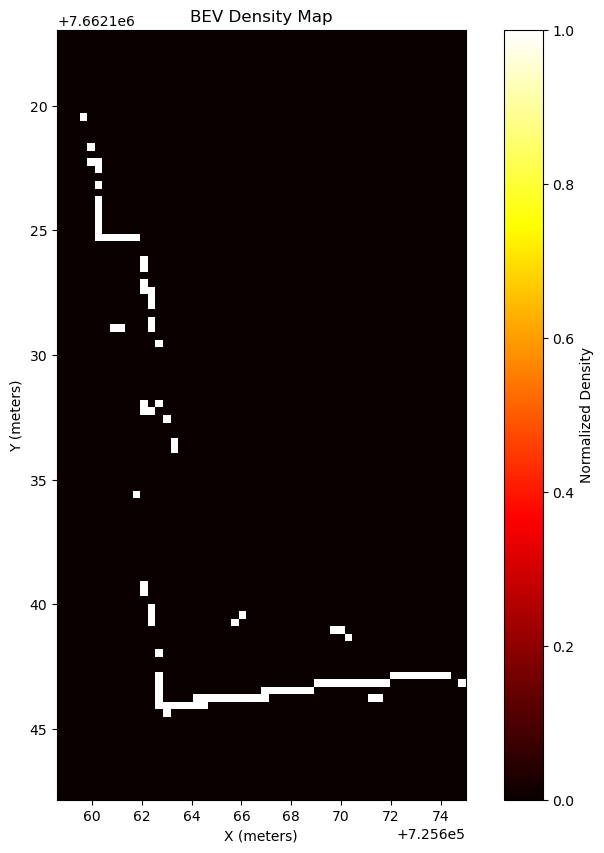

In [14]:
# Define x_limits and y_limits based on the extent of filtered points
x_limits = (filtered_points[:, 0].min(), filtered_points[:, 0].max())
y_limits = (filtered_points[:, 1].min(), filtered_points[:, 1].max())
resolution = 0.3  # meters

# Create BEV density map
bev_density_map = create_bev_density_map(points, x_limits, y_limits, resolution)
bev_density_map_thresh = bev_density_map>0.3

# Visualize the density map
plt.figure(figsize=(10, 10))
plt.imshow(bev_density_map_thresh, cmap="hot", extent=[*x_limits, *y_limits])
plt.colorbar(label="Normalized Density")
plt.title("BEV Density Map")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.gca().invert_yaxis()  # Invert y-axis to match BEV perspective
plt.show()


In [33]:
# Apply Gaussian filtering to smooth the density map
# smoothed_map = gaussian_filter(bev_density_map.astype(np.float32), sigma=2)

# Detect lines using Gaussian Mixture Model
X, Y = np.meshgrid(
    np.linspace(x_limits[0], x_limits[1], bev_density_map.shape[1]),
    np.linspace(y_limits[0], y_limits[1], bev_density_map.shape[0])
)
coords = np.vstack((X[bev_density_map_thresh > 0].ravel(), Y[bev_density_map_thresh > 0].ravel())).T

gmm = GaussianMixture(n_components=2, random_state=42).fit(coords)
line_centers = gmm.means_
line_covariances = gmm.covariances_

c:\Users\lliu\miniconda3\envs\floorheight\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


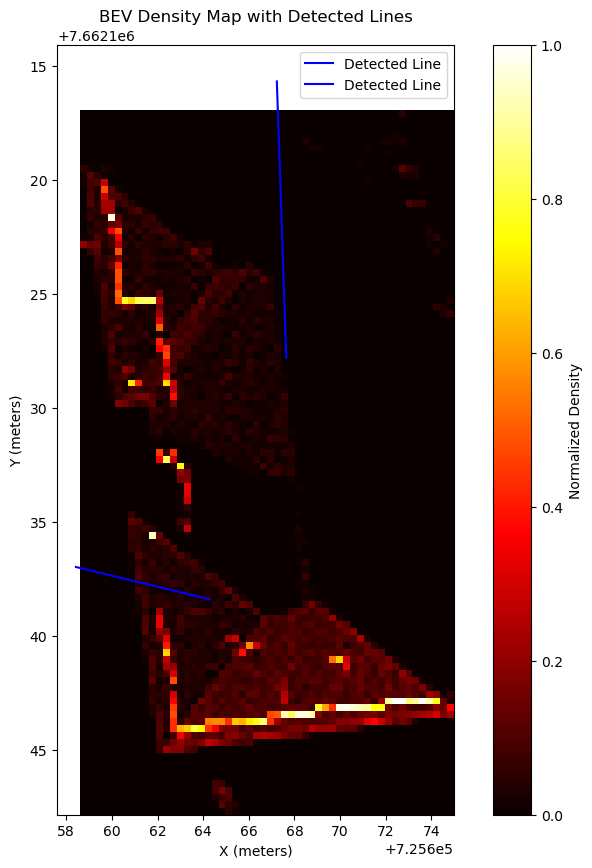

In [34]:
# Visualize the results
# Draw points along the lines represented by the GMM
line_points = []
for mean, cov in zip(line_centers, line_covariances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov[:2, :2])
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(-5, 5, 500)  # Generate points along the line
    line = mean[:2] + t[:, None] @ (eigenvectors[:, 0][None, :] * np.sqrt(eigenvalues[0]))
    line_points.append(line)
plt.figure(figsize=(10, 10))
plt.imshow(bev_density_map, cmap="hot", extent=[*x_limits, *y_limits])
plt.colorbar(label="Normalized Density")
for line in line_points:
    plt.plot(line[:, 0], line[:, 1], c="blue", label="Detected Line")
# plt.scatter(line_centers[:, 0], line_centers[:, 1], c="blue", label="Detected Lines", s=50)
plt.title("BEV Density Map with Detected Lines")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.gca().invert_yaxis()  # Invert y-axis to match BEV perspective
plt.legend()
plt.show()